# Final Project: Used Car Price Predictor
### Author: Satish Agrawal, Sanjay Jaras
### Bellevue University
### DSC 630 - Predictive Analytics

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpv
import types
import seaborn as sns

from sklearn import __version__ as sklv
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression

In [2]:
print('Using version %s of pandas' % pd.__version__)
print('Using version %s of numpy' % np.__version__)
print('Using version %s of matplotlib' % mpv)
print('Using version %s of seaborn' % sns.__version__)
print('Using version %s of sklearn' % sklv)

Using version 1.2.0 of pandas
Using version 1.19.2 of numpy
Using version 3.3.2 of matplotlib
Using version 0.11.1 of seaborn
Using version 0.23.2 of sklearn


## Configurations


In [3]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)

## Load Data
Data downloaded from https://www.kaggle.com/austinreese/craigslist-carstrucks-data


In [4]:
org_df = pd.read_csv("vehicles.csv", index_col=[0], converters={"cylinders":str})

### Show summary

In [5]:
org_df.shape

(458213, 25)

In [6]:
org_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


### Show Original Data types

In [7]:
org_df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object

### Let's drop column that we will not be using

In [8]:
# dropping columns which are not directly correlated to the target variable
df_sel = org_df.drop(columns=['url', 'id','image_url', 'description', 'region_url', 'VIN'])

### Convert posting date to date time

In [9]:
df_sel["posting_date"]=pd.to_datetime(df_sel.posting_date, utc=True)

### Rename size column name to avoid keyword issue

In [10]:
df_sel.rename(columns={"size":"size_"}, inplace=True)

In [11]:
df_sel.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size_,type,paint_color,state,lat,long,posting_date
0,auburn,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,rwd,NaN,other,NaN,al,32.590000,-85.480000,2020-12-02 14:11:30+00:00
1,auburn,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,al,32.547500,-85.468200,2020-12-02 08:11:50+00:00
2,auburn,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,al,32.616807,-85.464149,2020-12-02 01:50:41+00:00
3,auburn,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,al,32.861600,-85.216100,2020-12-01 21:54:45+00:00
4,auburn,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,al,32.547500,-85.468200,2020-12-01 18:53:56+00:00


### Distribution and outlier for years

In [12]:
df_sel.year.describe()

count    457163.000000
mean       2010.746067
std           8.868136
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2016.000000
max        2021.000000
Name: year, dtype: float64

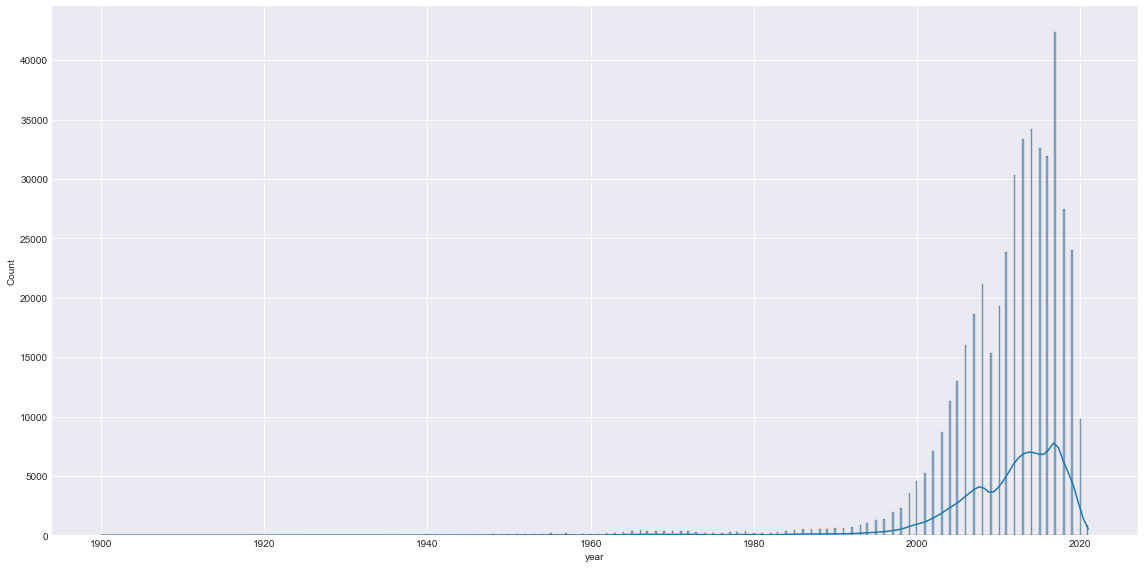

In [13]:
sns.displot(x=df_sel.year, kde=True, height=8, aspect=2 )
plt.show()

### Drop Records older than year 1995 and newer than 2020

In [14]:
df_sel = df_sel[(df_sel.year>1994) & (df_sel.year<2021)]

In [15]:
df_sel.year.describe()

count    440927.000000
mean       2011.939500
std           5.371592
min        1995.000000
25%        2008.000000
50%        2013.000000
75%        2016.000000
max        2020.000000
Name: year, dtype: float64

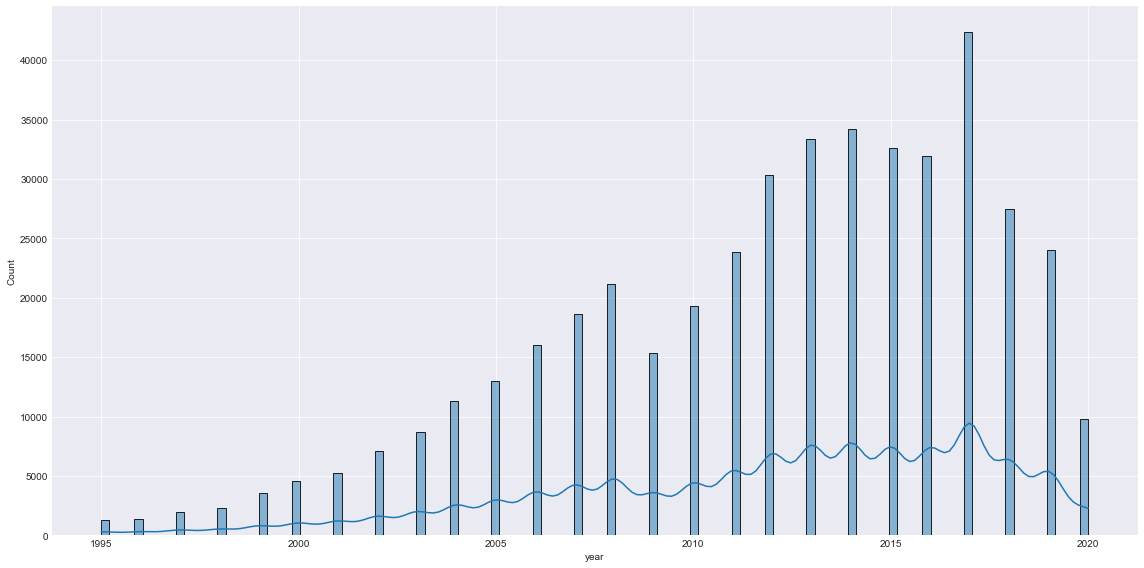

In [16]:
sns.displot(x=df_sel.year, kde=True, height=8, aspect=2 )
plt.show()

### Distribution and outlier for odometer

In [17]:
df_sel.odometer.describe()

count    3.915190e+05
mean     1.012058e+05
std      3.274094e+06
min      0.000000e+00
25%      4.125700e+04
50%      8.803500e+04
75%      1.342700e+05
max      2.043756e+09
Name: odometer, dtype: float64

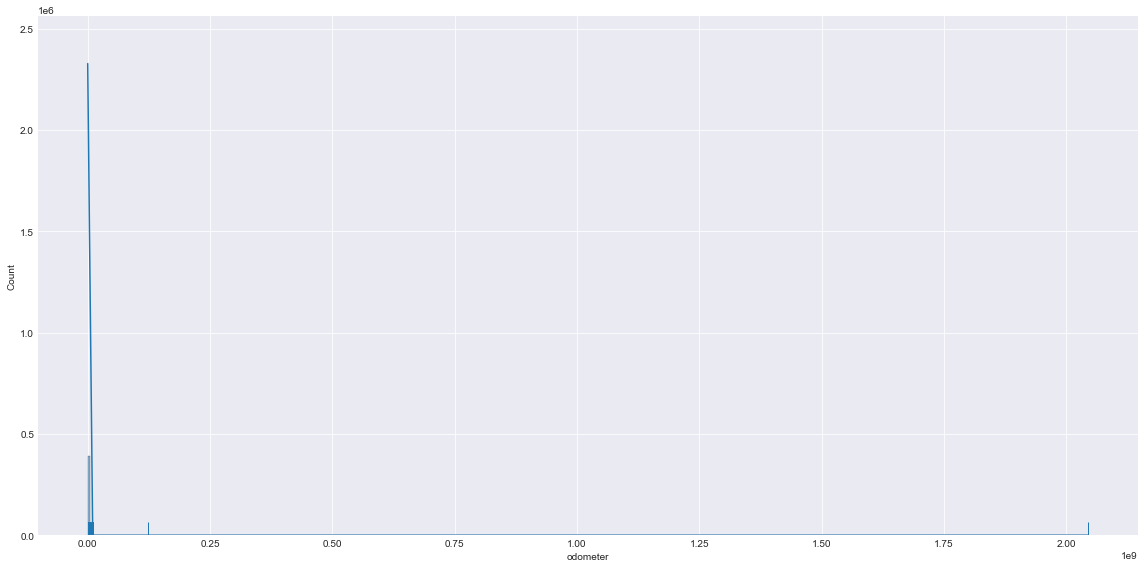

In [18]:
sns.displot(x=df_sel.odometer, kde=True, rug=True, height=8, bins=500, aspect=2 )
plt.show()

### Drop records with odometer greater than 200000

In [19]:
df_sel = df_sel[df_sel.odometer<200000]

In [20]:
df_sel.odometer.describe()

count    369951.000000
mean      85051.851086
std       52370.899858
min           0.000000
25%       39171.500000
50%       83000.000000
75%      125607.000000
max      199999.000000
Name: odometer, dtype: float64

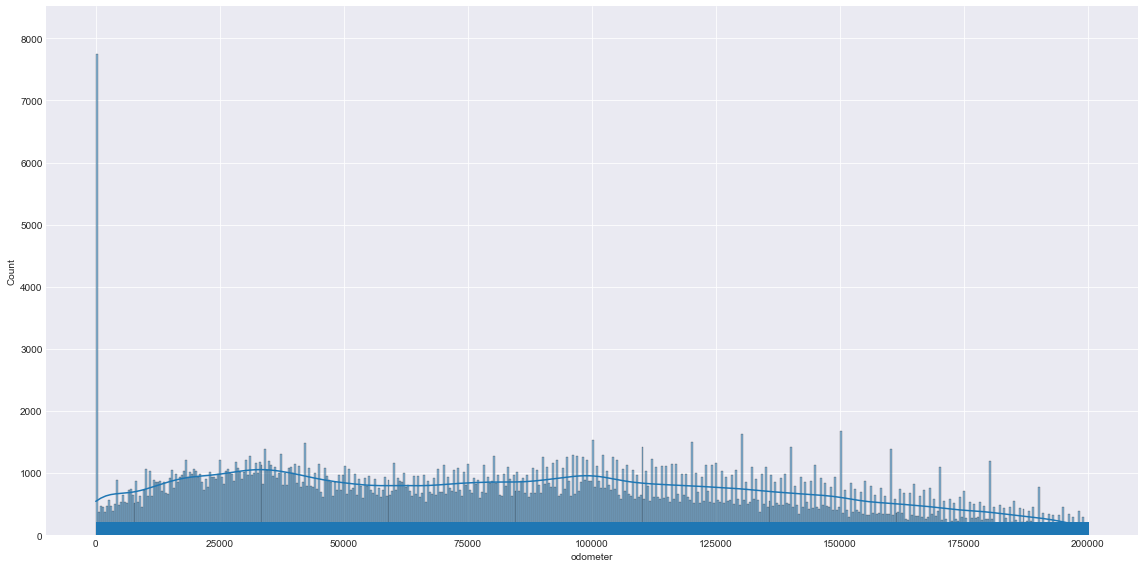

In [21]:
sns.displot(x=df_sel.odometer, kde=True, rug=True, height=8, bins=500, aspect=2 )
plt.show()

### Distribution and outlier for price

In [22]:
df_sel.price.describe()

count    3.699510e+05
mean     2.639712e+04
std      5.949605e+06
min      0.000000e+00
25%      5.900000e+03
50%      1.250000e+04
75%      2.299500e+04
max      3.615215e+09
Name: price, dtype: float64

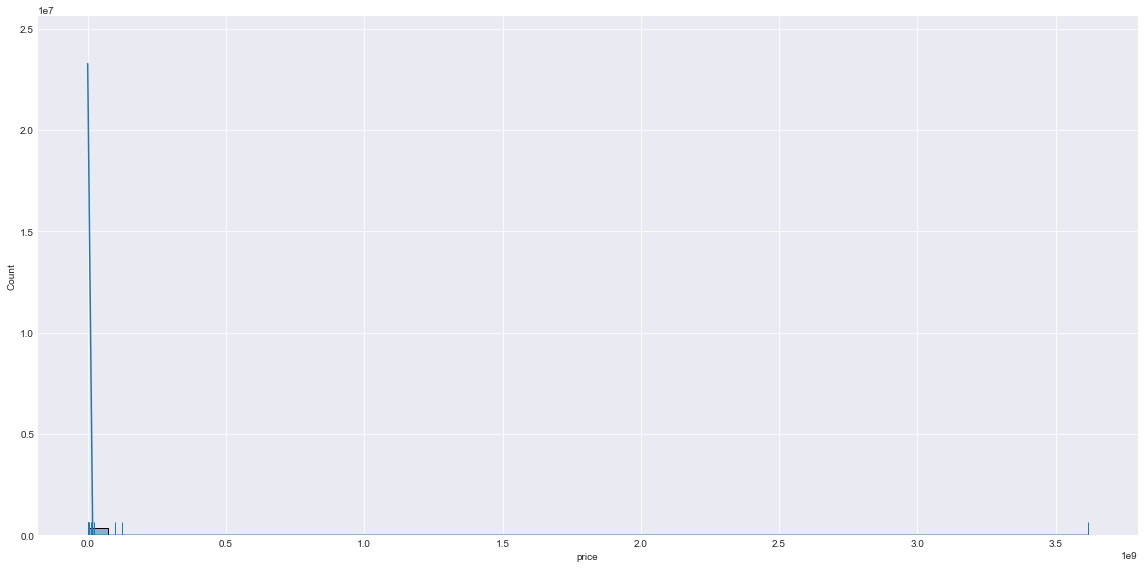

In [23]:
sns.displot(x=df_sel.price, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Drop records with price greater than 300000

In [24]:
df_sel = df_sel[df_sel.price<300001]

In [25]:
df_sel.price.describe()

count    369930.000000
mean      15866.009134
std       14125.215160
min           0.000000
25%        5900.000000
50%       12500.000000
75%       22995.000000
max      299988.000000
Name: price, dtype: float64

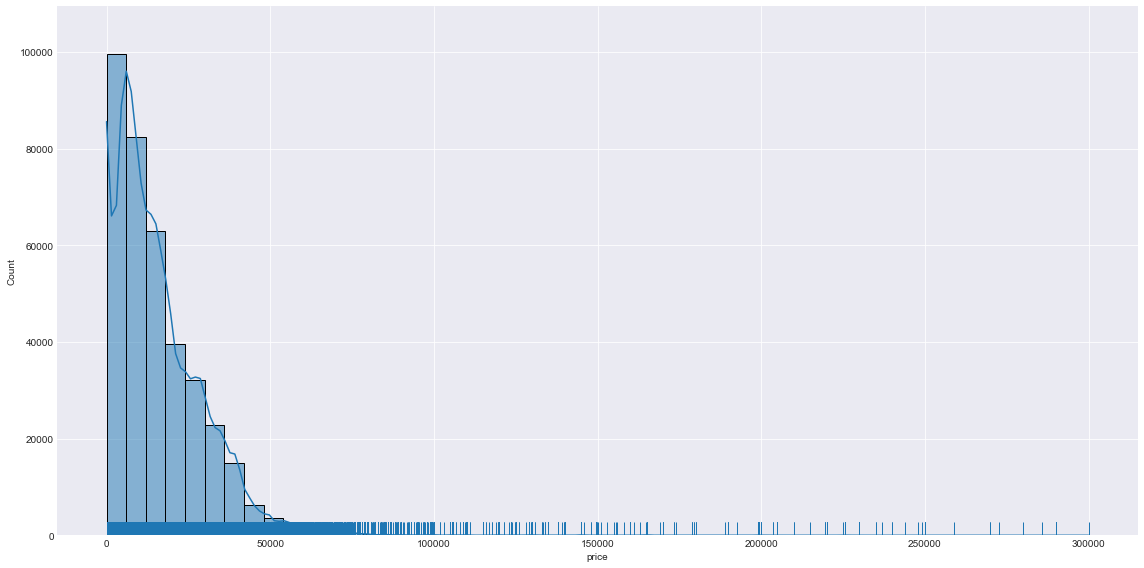

In [26]:
sns.displot(x=df_sel.price, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Convert variables to appropriate data types

### Replace unknown and blank cylinder values with None

In [27]:
def replace_cylinders(x):
    
    if x == None or x.strip() == "" or x.strip() == "other":
        return None
    else: 
        return x.replace(" cylinders", "").strip()

### Need to replace "other" to something else from Cylinders
#df_sel.cylinders = df_sel.cylinders.apply(lambda x : replace_cylinders(x))

### Find Missing Values

In [28]:
df_sel.isnull().sum()

region               0
price                0
year                 0
manufacturer      9556
model             2202
condition       149311
cylinders            0
fuel              2312
odometer             0
title_status      1615
transmission      1608
drive            90939
size_           257084
type             66481
paint_color      95253
state                0
lat               6846
long              6846
posting_date         0
dtype: int64

<AxesSubplot:>

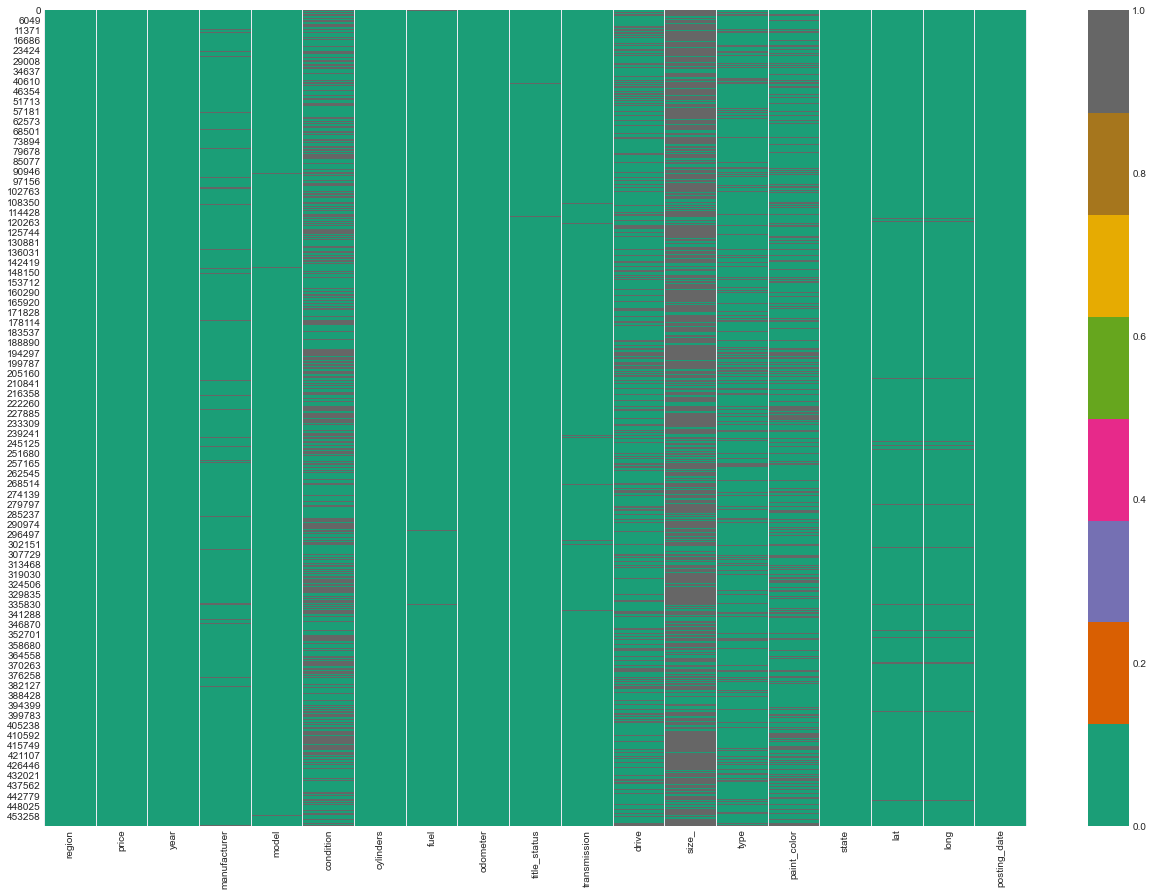

In [29]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.heatmap(df_sel.isnull(), cmap="Dark2")

In [30]:
num_attr = ["year", "odometer", "lat", "long"]
cat_attr = ["region", "manufacturer", "model", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size_", "paint_color", "state", "type"]

### Fill missing values wiht Imputers

#### Convert categorical features to numeric using Label Encoder

In [31]:
# move target variable to last
price_col = df_sel.price
df_sel = df_sel.drop(columns=["price"])
df_sel["price"] = price_col

# Copy Data frame for Imputaion estimation
df_imputer = df_sel.copy()
label_encoder = LabelEncoder()
def labelEncode(catFeature):
    nonulls = np.array(catFeature.dropna())
    impute_reshape = nonulls.reshape(-1,1)
    impute_ordinal = label_encoder.fit_transform(impute_reshape)
    catFeature.loc[catFeature.notnull()] = np.squeeze(impute_ordinal)
    return catFeature

for catFeature in cat_attr:
    labelEncode(df_imputer[catFeature])
    

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [32]:
df_imputer.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size_,type,paint_color,state,lat,long,posting_date,price
0,16,2010.0,7,8197,2,7,2,32742.0,0,2,2,NaN,7,NaN,1,32.590000,-85.480000,2020-12-02 14:11:30+00:00,35990
1,16,2014.0,17,20422,0,4,2,93600.0,0,0,1,NaN,9,NaN,1,32.547500,-85.468200,2020-12-02 08:11:50+00:00,7500
2,16,2006.0,4,23288,2,6,2,87046.0,0,0,NaN,NaN,0,1,1,32.616807,-85.464149,2020-12-02 01:50:41+00:00,4900
4,16,2005.0,12,11904,0,7,0,116000.0,1,0,0,1,8,1,1,32.547500,-85.468200,2020-12-01 18:53:56+00:00,19500
5,16,2016.0,39,21271,2,6,2,33290.0,0,2,NaN,NaN,8,8,1,32.590000,-85.480000,2020-12-01 13:27:25+00:00,29590


In [33]:
drop_cols = []
drop_cols.append("posting_date")
#drop_cat.extend(num_attr)
#print(drop_cat)
df_imputer = df_imputer.drop(columns=drop_cols)

df_imputer.columns

Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size_',
       'type', 'paint_color', 'state', 'lat', 'long', 'price'],
      dtype='object')

### Find good estimator to fill missing values for categorical features

#### Simple Imputer

In [34]:
score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=df_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(df_imputer.iloc[:,-1:])
    estimator = make_pipeline(
                    SimpleImputer(missing_values=np.NaN, strategy=strategy),
                    BayesianRidge()
                )
    
    score_simple_imputer[strategy] = cross_val_score(estimator, 
                                                     X, 
                                                     y, 
                                                     scoring='neg_mean_squared_error',
                                                     cv=None
                                     )


#### Iterative Imputers

In [35]:
# Estimate the score on the entire dataset by filling missing values by different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=random_state),
    ExtraTreesRegressor(n_estimators=10, random_state=random_state, n_jobs=10),
    KNeighborsRegressor(n_neighbors=10, n_jobs=10),
    #SGDRegressor(random_state=random_state),
    Lasso(random_state=random_state)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=df_imputer.copy()
        for col in df_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
            
        X=df_new.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
        #print(X.isna().sum())
        #print(df_imputer.iloc[:,-1:].isna().sum())
        y = np.ravel(df_imputer.iloc[:,-1:])
        
        # Time being added this, need to investigate why imputer is returing columns with NaN
        X = X.fillna(X.median()).clip(-1e11,1e11)
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error')

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor
Estimating Lasso


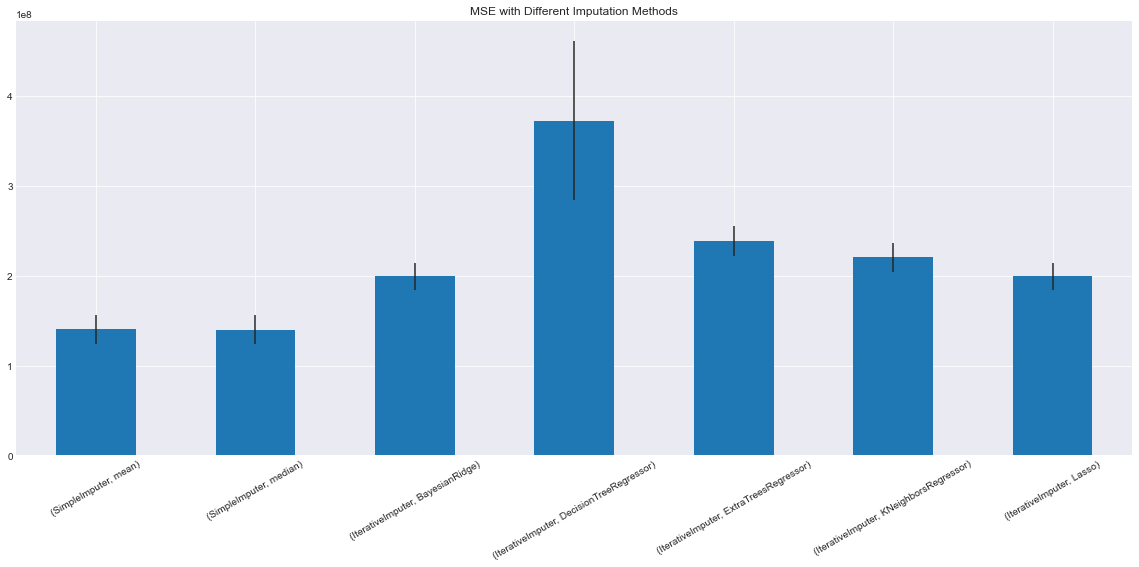



Method with Minimum Error ('IterativeImputer', 'BayesianRidge')


In [36]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax =plt.subplots(1,figsize=(20, 8))
means = -scores.mean()
errors = scores.std()
means.plot(kind="bar", yerr=errors)
plt.xticks(rotation=30)
plt.title("MSE with Different Imputation Methods")
plt.show()

print("\n\nMethod with Minimum Error", errors.idxmin())
name = errors.idxmin()

### Select Estimator for filling missing values

In [37]:
selected_est =  estimators[0]
print(selected_est)    

BayesianRidge()


### Fill missing values for Numerical Atrributes

In [38]:
df_sel.isnull().sum()[num_attr]

year           0
odometer       0
lat         6846
long        6846
dtype: int64

In [39]:
df_num=df_sel[num_attr]
imputer=IterativeImputer(selected_est) 
imputed_data=imputer.fit_transform(df_num)
df_sel[num_attr]=imputed_data

In [40]:
df_sel.isnull().sum()[num_attr]

year        0
odometer    0
lat         0
long        0
dtype: int64

### Fill missing values for Categorical Atrributes

In [41]:
df_sel.isnull().sum()[cat_attr]

region               0
manufacturer      9556
model             2202
condition       149311
cylinders            0
fuel              2312
title_status      1615
transmission      1608
drive            90939
size_           257084
paint_color      95253
state                0
type             66481
dtype: int64

In [42]:
# encode categorical columns to numbers
for catFeature in cat_attr:
    labelEncode(df_sel[catFeature])

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

X=df_sel.drop(columns=["lat", "long", "posting_date"])
print(X.columns)
for col in X.columns:
    X=X[X[col] >=0]


features_df=X.drop(columns="price")
print(X.shape)
target = X.price
#X_new = SelectKBest(chi2, k=15).fit_transform(X.iloc[:,:-1], X.price)

# Create and fit selector
selector = SelectKBest(f_classif, k=12)
selector.fit(features_df, target)
cols = selector.get_support(indices=True)
features_df_new = features_df.iloc[:,cols]

print(features_df_new.columns)
print(features_df_new.shape)

Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size_',
       'type', 'paint_color', 'state', 'price'],
      dtype='object')
(78834, 16)
Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'transmission', 'drive', 'type', 'paint_color', 'state'],
      dtype='object')
(78834, 12)


[ 1.57710055 14.69364795  1.9922636   1.94646439  2.67718121  3.8094296
  7.29536073  8.5901879   1.45338258  3.12447403  3.12177047  1.62509754
  2.25258824  2.09341661  1.96301228]


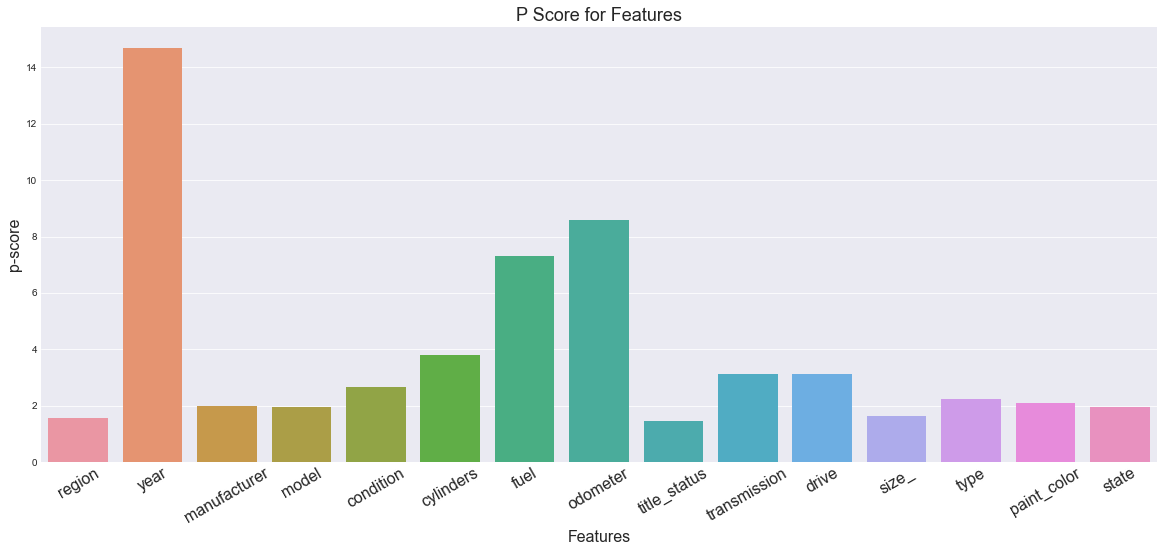

In [84]:
### P-Scores for columns
print(selector.scores_)

#X.columns[:-1]
fig, ax =plt.subplots(1,figsize=(20, 8))
sns.barplot(x=X.columns[:-1], y=selector.scores_)
plt.xticks(rotation=30, fontsize=16)
plt.xlabel("Features", fontsize=16)
plt.ylabel("p-score", fontsize=16)
plt.title("P Score for Features", fontsize=18)
plt.show()

In [45]:
    
# Fill missing values
df_cat=df_sel[cat_attr]
imputer=IterativeImputer(selected_est) 
imputed_data=imputer.fit_transform(df_cat)
df_sel[cat_attr]=imputed_data

In [46]:
df_sel.isnull().sum()[cat_attr]

region          0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size_           0
paint_color     0
state           0
type            0
dtype: int64

### Add age column from model year and posting date

In [47]:
class AddAgeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, year_col_idx, posting_date_idx): # no *args or **kargs
        self.year_col_idx = year_col_idx
        self.posting_date_idx = posting_date_idx
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        inp = X.values
        year = (inp[:, self.year_col_idx] - 1).astype(int).astype(str)
        manu_year=np.char.add(year, "/09/30")
        manu_date = pd.to_datetime(manu_year, format="%Y/%m/%d", utc=True)
        ser = pd.Series(inp[:, self.posting_date_idx])
        print(ser.dtypes)
        diff = pd.to_datetime(ser).subtract(manu_date)
        return np.c_[(diff/np.timedelta64(1, 'M'))]

attr_adder = AddAgeColumn(df_sel.columns.get_loc("year"), df_sel.columns.get_loc("posting_date"))
age_col = attr_adder.transform(df_sel)

datetime64[ns, UTC]


In [48]:
df_sel["age_in_months"] = age_col
df_sel.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size_,type,paint_color,state,lat,long,posting_date,price,age_in_months
0,16.0,2010.0,7.0,8197.0,2.0,7.0,2.0,32742.0,0.0,2.0,2.000000,1.004712,7.0,5.949909,1.0,32.590000,-85.480000,2020-12-02 14:11:30+00:00,35990,134.100210
1,16.0,2014.0,17.0,20422.0,0.0,4.0,2.0,93600.0,0.0,0.0,1.000000,1.139523,9.0,6.203254,1.0,32.547500,-85.468200,2020-12-02 08:11:50+00:00,7500,86.091018
2,16.0,2006.0,4.0,23288.0,2.0,6.0,2.0,87046.0,0.0,0.0,0.546871,1.288705,0.0,1.000000,1.0,32.616807,-85.464149,2020-12-02 01:50:41+00:00,4900,182.084293
4,16.0,2005.0,12.0,11904.0,0.0,7.0,0.0,116000.0,1.0,0.0,0.000000,1.000000,8.0,1.000000,1.0,32.547500,-85.468200,2020-12-01 18:53:56+00:00,19500,194.066817
5,16.0,2016.0,39.0,21271.0,2.0,6.0,2.0,33290.0,0.0,2.0,0.884381,0.937627,8.0,8.000000,1.0,32.590000,-85.480000,2020-12-01 13:27:25+00:00,29590,62.081298


### distribution plot for age in months

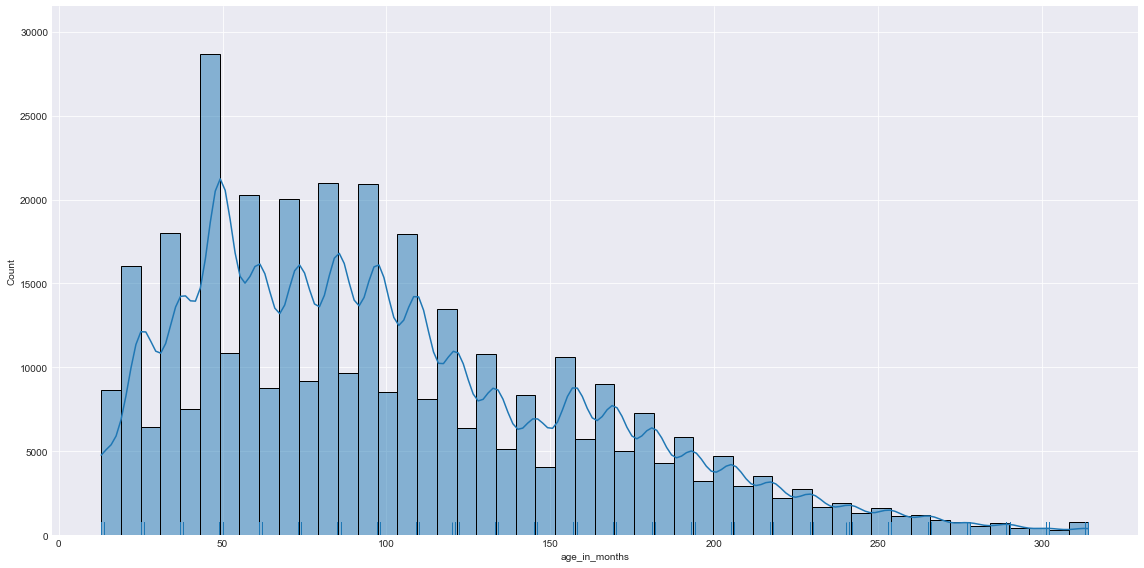

In [49]:
sns.displot(x=df_sel.age_in_months.astype(int), kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Drop column posting date

In [50]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return  X[[b for b in list(X.columns) if b != self.attribute_name]]
        return X[self.attribute_names].values

drop_col = DropColumns("posting_date")
df_sel = pd.DataFrame( drop_col.transform(df_sel))

### Columns Selector

In [51]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
num_sel = ColumnSelector(num_attr)
df_num_attrs = num_sel.transform(df_sel)

In [52]:
old_cat_pipeline = Pipeline([
        ('selector', ColumnSelector(cat_attr)),
        ('cat_encoder', OneHotEncoder()),
    ])
cat_pre = old_cat_pipeline.fit_transform(df_sel)

### Pipeline for outlier removal

In [53]:
class OutlierExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, attrmap ):
        self.attrmap = attrmap

    def transform(self, X):
        for attr in self.attrmap:
            val = self.attrmap[attr]
            min, max = X[attr].quantile([val[0], val[1]])
            X = X[(X[attr]>=min) & (X[attr]<=max)]
        return X

    def fit(self, X, y = None):
        return self
    
est = OutlierExtraction({"price":[0.15, 0.95], "year":[0.10, 0.999],"odometer":[0, 0.90]})
test_df = est.fit_transform(org_df)

In [54]:
org_df.odometer.quantile([0.15, 0.90])


0.15     25737.0
0.90    176779.0
Name: odometer, dtype: float64

In [55]:
org_df.price.describe()

count    4.582130e+05
mean     4.042093e+04
std      8.194599e+06
min      0.000000e+00
25%      4.900000e+03
50%      1.099500e+04
75%      2.149500e+04
max      3.615215e+09
Name: price, dtype: float64

### Pipeline for Numeric columns

In [56]:
num_pipeline = Pipeline([('selector', ColumnSelector(num_attr)),
                         ('imputer', IterativeImputer(BayesianRidge())),                           
                         ('scaler', StandardScaler())])
test = num_pipeline.fit_transform(org_df) 

In [57]:
est = OutlierExtraction({"price":[0.15, 0.95], "year":[0.10, 0.999],"odometer":[0, 0.90]})
test_df = est.fit_transform(org_df)
df_inp = pd.DataFrame(test_df)
df_inp["posting_date"]=pd.to_datetime(df_inp.posting_date, utc=True)
add_age_pipeline = Pipeline([('add_age', AddAgeColumn(df_inp.columns.get_loc("year"), df_inp.columns.get_loc("posting_date"))),
                     ('scaler', StandardScaler())])
test_age = add_age_pipeline.fit_transform(df_inp)

datetime64[ns, UTC]


### Pipeline for Categorical Columns

In [58]:
class CatLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X):
        df = pd.DataFrame()
        for attr in range(X.shape[1]): 
            col = pd.Series(X[:, attr])
            cat_col = labelEncode(col)
            df[attr] = cat_col.ravel()
        return df.to_numpy()

    def fit(self, X, y = None):
        return self

cat_attr = ["region", "manufacturer", "model", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size", "paint_color", "state", "type"]
cat_pipeline = Pipeline([('selector', ColumnSelector(cat_attr)), 
                         ('labelEncoder', CatLabelEncoder()),
                        ('imputer', IterativeImputer(BayesianRidge()))])
test_cat = cat_pipeline.fit_transform(org_df)

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [59]:
cat_attr = ["manufacturer", "model", "condition", "cylinders", "fuel", "transmission", "drive", "paint_color", "state", "type"]
cat_pipeline = Pipeline([('selector', ColumnSelector(cat_attr)),
                         ('labelEncoder', CatLabelEncoder()),
                        ('imputer', IterativeImputer(BayesianRidge())),
                        ('onehotEncoding', OneHotEncoder())])
test_cat = cat_pipeline.fit_transform(org_df)

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Remove Outliers

In [60]:
est = OutlierExtraction({"price":[0.15, 0.95], "year":[0.10, 0.999],"odometer":[0, 0.90]})
test_df = est.fit_transform(org_df)
df_inp = pd.DataFrame(test_df)
# for converting to date time
df_inp["posting_date"]=pd.to_datetime(df_inp.posting_date, utc=True)


### Full Pipeline

In [61]:
# Outlier removal
full_pipeline = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
        ("num_pipeline", num_pipeline),
        ("add_age_col", add_age_pipeline)
    ])

df_prepared = full_pipeline.fit_transform(df_inp)
df_for_split = pd.DataFrame(df_prepared)
df_for_split["price"] = df_inp.price
#test_prepared = full_pipeline.fit_transform(test_set)

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


datetime64[ns, UTC]


### Split dataset for training and testing

In [62]:
train_set, test_set, train_y, test_y = train_test_split(df_prepared, df_inp.price, test_size=0.2, random_state=random_state)

### Model

In [63]:
lin_reg = LinearRegression()
lin_reg.fit(train_set, train_y)

LinearRegression()

In [64]:
#some of models will predict neg values so this function will remove that values
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
def remove_neg(y_test,y_pred):
    ind=[index for index in range(len(y_pred)) if(y_pred[index]>0)]
    y_pred=y_pred[ind]
    y_test=y_test[ind]
    y_pred[y_pred<0]
    return (y_test,y_pred)

def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])

In [65]:
y_pred=lin_reg.predict(test_set)

y_test_1,y_pred_1=remove_neg(test_y.to_numpy(),y_pred)
r1_lr=result(y_test_1,y_pred_1)
print('Coefficients: \n', lin_reg.coef_)
print("MSLE : {}".format(r1_lr[0]))
print("Root MSLE : {}".format(r1_lr[1]))
print("R2 Score : {} or {}%".format(r1_lr[2],r1_lr[3]))
accu['Linear Regression']=r1_lr

Coefficients: 
 [  -134.13309077   5169.92808464  10277.64482028 ...    428.17098423
   -147.30739557 -19198.42651048]
MSLE : 0.10661429343747887
Root MSLE : 0.3265184427218145
R2 Score : 0.8897246505154432 or 88.9725%
